In [1]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

### Data preparation

In [2]:
def txt_to_matrix(filename, line_skip = 5):
    f = open (filename, 'r')
    
    # Lineskip, cleaning, conversion
    data = f.readlines()[line_skip:]
    
    return np.asarray(
        [l.replace("\n", "").split() for l in data]
    ).astype(np.float64)

In [3]:
def get_time_step(root, index):

    wse = txt_to_matrix(root + '/decoded--' + index + '.WSE')
    dep = txt_to_matrix(root + '/decoded--' + index + '.DEP')
    vvx = txt_to_matrix(root + '/decoded--' + index + '.VVX')
    vvy = txt_to_matrix(root + '/decoded--' + index + '.VVY')

    # timestep: matrice 801 rows x 4 misurazioni x 1256 colonne (valori)
    return np.array(list(zip(wse, dep, vvx, vvy)))

def get_dep_time_step(root, index):

    dep = txt_to_matrix(root + '/decoded--' + index + '.DEP')

    # timestep: matrice 801 rows x 4 misurazioni x 1256 colonne (valori)
    return np.array(dep)

In [4]:
rootdir = '../output/'
timesteps = []

paths = [p for p in sorted(os.listdir('../output'))]
x = 0
ceiling = 50

# Read all dirs and process them
for path in tqdm.tqdm(paths):
    
    if x >= ceiling: break
    
    # Processing
    path = rootdir + path
    timesteps.append(
        get_dep_time_step(
            path, ("{:04d}".format(x))
        )
    )
    x += 1
        
timesteps = np.asarray(timesteps).astype(np.float32)

 94%|█████████▍| 50/53 [00:23<00:01,  2.09it/s]


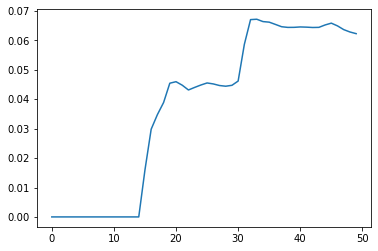

In [5]:
plt.plot(timesteps[:, 401, 600])

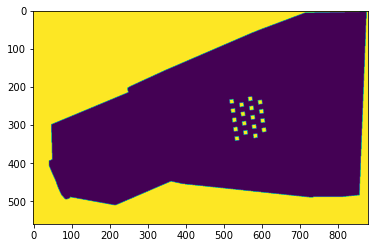

In [16]:
from skimage.transform import rescale, resize, downscale_local_mean

sample = timesteps[10, :, :]

ratio = 0.7
s_x = int(sample.shape[0] * ratio)
s_y = int(sample.shape[1] * ratio)

sample = resize(sample, (s_x, s_y))

plt.imshow(sample)

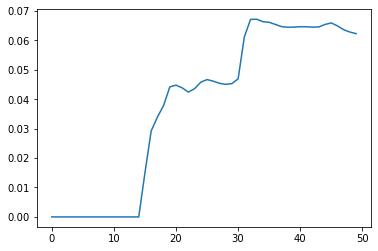

In [17]:
dataset = timesteps[:, :, :].astype(np.float64)

plt.plot(dataset[:, 400, 600])

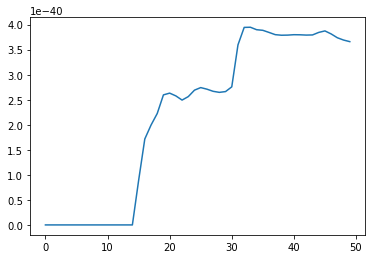

In [18]:
dataset_min = dataset.min(axis=(1, 2), keepdims=True)
dataset_max = dataset.max(axis=(1, 2), keepdims=True)
norm = ((dataset - dataset_min)/(dataset_max - dataset_min))

plt.plot(norm[:, 400, 600])

In [19]:
dataset = norm

### Building the net

In [20]:
import torch.nn as nn
import torch.nn.functional as F
import torch

In [21]:
if torch.cuda.is_available():  
  dev = "cuda:0"
else:
  dev = "cpu"

device = torch.device(dev)

In [22]:
class LiNet(torch.nn.Module):
    
    #Our batch shape for input x is (3, 32, 32)
    
    def __init__(self, w = 801, h = 1256):
        super(LiNet, self).__init__()

        # DNN
        self.fc1 = torch.nn.Linear(s_x * s_y, 256)
        self.fc2 = torch.nn.Linear(256, 128)
        self.fc3 = torch.nn.Linear(128, 256)
        self.fc4 = torch.nn.Linear(256, s_x * s_y)
        
    def forward(self, x):
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        return(x)

net = LiNet().to(device)

In [23]:
import torch.optim as optim
from torchvision import transforms, utils

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Training
# primo frame
in_x = dataset[0, :, :]

In [24]:
from copy import deepcopy

losses = []

for epoch in range(10):
    
    frame = 0
    
    epoch_loss = []
    for out_x in dataset[1:, :,:]:

        sample = torch.FloatTensor(resize(in_x, (s_x, s_y))).to(device)
        y = torch.FloatTensor(resize(out_x, (s_x, s_y))).flatten().to(device)
        
        #sample = torch.FloatTensor(in_x).to(device)
        #y = torch.FloatTensor(out_x).flatten().to(device)
              
        sample = sample.flatten()
        
        # Compute
        y_hat = net(
            sample
        ).to(device)
        
        # Loss
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        
        epoch_loss.append(loss.item())

        # Next step
        in_x = deepcopy(out_x)
        frame += 1
        
    avg = np.asarray(epoch_loss).mean()
    losses.append(avg)
    print("Epoch {} - avg.loss: {}".format(epoch, avg))

Epoch 0 - avg.loss: 2.709629848599434
Epoch 1 - avg.loss: 0.17184973686781466
Epoch 2 - avg.loss: 0.11363635174169832
Epoch 3 - avg.loss: 0.18647257253831748
Epoch 4 - avg.loss: 0.08508550284468398
Epoch 5 - avg.loss: 0.052718628349961064
Epoch 6 - avg.loss: 0.11804726050824535
Epoch 7 - avg.loss: 0.06173397973179817
Epoch 8 - avg.loss: 0.039571319573691914
Epoch 9 - avg.loss: 0.04916412474549547


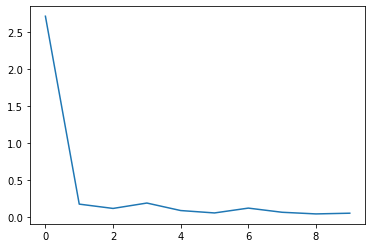

In [25]:
plt.plot(losses)